[![Segmentation](https://github.com/ttompk/musings/blob/master/images/t-dist.png?raw=true "Troy's Github")](https://github.com/ttompk/uscf_grinberg_neuro_images/tree/troy) ![Troy](https://github.com/ttompk/musings/blob/master/images/seg.png?raw=true)

# UCSF Neuron Segmentation - Fastai for Image Segmentation
---

[Today's Date]  
Written in python: 3.7.4

In [1]:
from platform import python_version
import os
print('Your python version: {}'.format(python_version()))
print('Development environment: {}'.format(os.environ['CONDA_DEFAULT_ENV']))
# this code prevents memory leakage
os.environ['FASTAI_TB_CLEAR_FRAMES']="1"

Your python version: 3.7.3
Development environment: base


### To Dos:

- split images into equal pieces for training (500x500?)
- no metrics (ex. accuracy) on the validation set at this point. I believe this is due to training images and validation image being different sizes. Currently throws a pytorch error if metric included. 
- when we overlay the training masks on the images - one image appears green while the other is blue - is that a problem???


## Notebook TOC
---
1. Overview
2. Libraries
3. Generalized Functions
4. Data ETL
5. Analysis
6. Conclussion
7. Next Steps

## 1. Overview
---
This notebook was developed for image sementation using the Fastai library. Segmentation is predicting the class of each pixel in an image.

### Directive/Objective
Identify NeuN stained neurons in microscopy slides and measure amount of co-localization with other staining markers (different channels than NeuN). 

**Part 1**  
Segmentation. Identify the NeuN-stained neurons using the fastai library.

**Part 2**  
Perform co-localization of the neurons with other channels. Obtain location of neuron segmentation (perhaps return colormap). 

**Part 3**  
Package the tool for use in ImageJ - either as a plug-in or other method (see ImageJ developer tools). Will require tool to be validated on several image sizes.


### Data Source
Each image in the 'images' subfolder has an equivalent in 'labels'. The 'labels' are the expertly labeled segmentation masks. 

This is the link to the GCP 'storage' folder. [link to data]()

## 2. Libraries
---

In [2]:
# basic kit - included in default anaconda env list
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import os
from pathlib import Path
#import pandas_profiling
import re
import collections

In [3]:
from fastai.vision import *
from fastai.callbacks import *
from PIL import Image as pil_image
from src.img_functions import *

In [4]:
%load_ext autoreload
%autoreload 2

## 3. Generalized Functions
---

In [5]:
# functions moved to img_functions.py

## 4. Data
---

### Access data from Google storage directly.
**-- Note:  This process is not currently working**

In [5]:
from src import google_storage as gs
# set google connection credentials in the environment
# this file is derived via the console. 

# connecting to storage
project_id = "ucsf-galvanize-brain-image-rec"
bucket_name = "ucsf-neuron-images"

bucket = gs.Connect_Bucket(project_id, bucket_name)

# list the files within bucket
#bucket.list_blobs()

In [5]:
# list the files within bucket
#bucket.list_blobs()

In [6]:
# set the folder path
#file_to_open = "images_sliced/0-0-TrainingData_1_original.tif"
#bucket.get_file(file_to_open)

### 4.1 Define classification classes
Class names are stored in a text file.

In [6]:
# load the class definitions
codes = np.loadtxt('data/codes.txt', dtype=str)    # these are the classes
# in dataframe for printing only
pd.DataFrame(codes)

,0
0,background
1,neuron


### 4.2 Training images - Local Files

In [7]:
# standard size of images
size = 250

In [8]:
# image folder name
img_folder_name = "{}_{}".format('data/images_sliced',str(size))

In [9]:
# images
#path_img = Path('data/images_beta')   # images go here
#path_img = Path('data/images_sliced')   # original sliced images folder (300x300)
path_img = Path(img_folder_name)   # 250x250 images
img_names = get_image_files(path_img)  # a list of posixpath filenames

There are 366 image files.
First 3 image files:
0:	Name: data/images_sliced_250/0-250-TrainingData_8_original_3.tif
	Shape: torch.Size([3, 250, 250])

1:	Name: data/images_sliced_250/500-2750-TrainingData_1_original.tif
	Shape: torch.Size([3, 250, 250])

2:	Name: data/images_sliced_250/1500-2500-TrainingData_3_original.tif
	Shape: torch.Size([3, 250, 250])

3:	Name: data/images_sliced_250/250-0-TrainingData_8_original_12.tif
	Shape: torch.Size([3, 250, 250])

Minimum width: 250
Minimum height: 250
Size of images in this directory: [(250, 250), (250, 250), (250, 250), (250, 250), (250, 250), (250, 250), (250, 250), (250, 250), (250, 250), (250, 250), (250, 250), (250, 250), (250, 250), (250, 250), (250, 250), (250, 250), (250, 250), (250, 250), (250, 250), (250, 250), (250, 250), (250, 250), (250, 250), (250, 250), (250, 250), (250, 250), (250, 250), (250, 250), (250, 250), (250, 250), (250, 250), (250, 250), (250, 250), (250, 250), (250, 250), (250, 250), (250, 250), (250, 250), (250, 

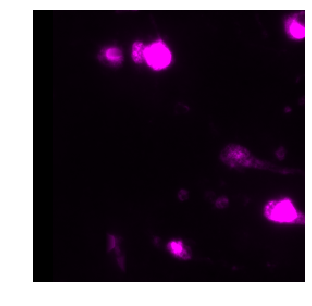

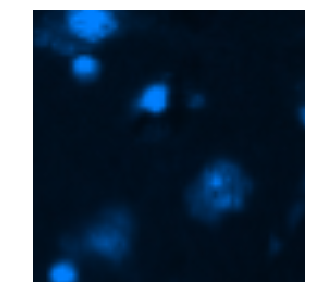

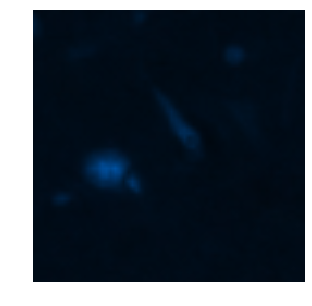

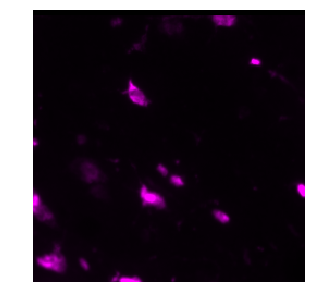

In [10]:
# Print out info on the training images.
train_img_test(img_names, open_image)

### 4.3 Image masks...aka labels

In [11]:
# write function to map greyscale (0-255) values to sequential integers:
# Ex. array contains 0, 100, 212  -->  convert to 0,1,2
def convert_mask_to_seq_int():
    pass

In [12]:
# This function maps each image filename with corresponding mask filename.
# This function gets called when we define a 'data' object for training/validation.
# Label mask file names are same as training image filenames with addition of '_P' at the end.
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'    # only works wth PosixPath object

There are 366 image files.
First 3 image files:
---------------------
0
Name: data/images_sliced_250/0-250-TrainingData_8_original_3.tif
Size: Train - [250 250] 	Mask - [250 250]
Unique Color Classes:[0 1]
tensor([[[0, 0, 0,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 1, 1, 1],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]])
---------------------
1
Name: data/images_sliced_250/500-2750-TrainingData_1_original.tif
Size: Train - [250 250] 	Mask - [250 250]
Unique Color Classes:[0 1]
tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]])
---------------------
2
Name: data/images_sliced_250/1500-2500-TrainingData_3_original.tif
Size: Train - [250 250] 	Mask - [250 250]
Unique Color Classes:[0 1]
tensor([[[1, 1, 1,  ...

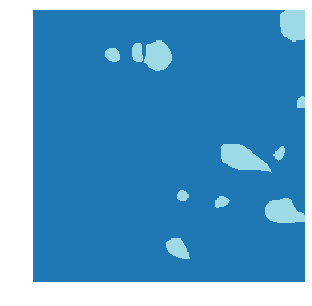

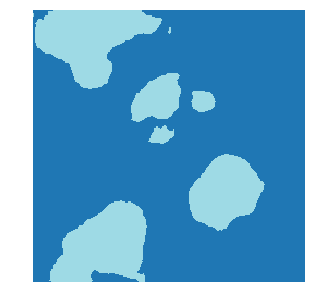

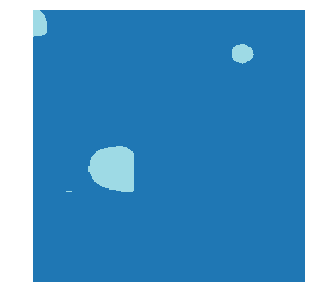

In [13]:
# load label images
#path_lbl = Path('data/labels_sliced', )   # labels from 300x300 sliced images
path_lbl = Path('data/labels_sliced_250', )   # labels from 250x250 sliced images - includes images 8 and 9
lbl_names = get_image_files(path_lbl)   # a list of posixpath filenames
label_info(img_names, lbl_names, get_y_fn)   # overview of training imgaes and masks

In [14]:
# display image in another window
#img_window(img_names[0])

#### 4.2 Define data object

[spliting training data into train/validation](https://docs.fast.ai/vision.data.html)


if CUDA error on JPG image load...then the tensor generated from the mask (ground truth map) 
may return values greater the number of classes. Example, 0.0001 and 0.000001 need to both be 0.
This code is intended to override the fastai 'open' method and processes the data as 0 or 1. Code 
needs to be optimized for current variables.

`from fastai.vision.image import open_image, pil2tensor, ImageSegment
class CustomSegmentationList(SegmentationItemList):
    def open(self, fn):
        x = open_image(fn, div=False).data
        x = pil2tensor(x, np.float32)
        return ImageSegment(x/x.max())
`

#### 4.2.1 Transform the data

In [15]:
# set transformations to training images
# flip_vert=True: randomly flip images horizontally and vertically
# max_warp=0.:  warping allows for change on perspective. To not use, set to 0. <- set to zero for satellites too

tfms = get_transforms(
    flip_vert=True,   # randomly flip images horizontally and vertically
    max_warp=0.0      # warping allows for change on perspective - not needed on microscope slides
)   

#### 4.2.2 Size data for modeling

In [16]:
# hyperparameters for 300
#train_img_size = 300
#bs = 12

# hyperparameters for 250
train_img_size = 250
bs = 12

In [17]:
# load image data from folder
data = (SegmentationItemList.from_folder(path_img)   # load the data from a folder
        .split_by_rand_pct(valid_pct=0.2)   # split data into training and validaiton sets by random percent
        #.split_by_fname_file('../valid.txt')   # split data by folder if text file present
        #.split_none()     # if no validation data
        #.label_from_func(get_y_fn, classes=codes, convert_mode='L')  # label data using 'get_y_fn' function
        .label_from_func(get_y_fn, classes=codes)  # label data using 'get_y_fn' function
        .transform(tfms, tfm_y=True, size=train_img_size)  # flip image horizontally, we need to use tfm_y=True in the transform call because we need the same transforms to be applied to the target mask as were applied to the image
        .databunch(bs=24, path=Path('data'))  # create a databunch, 'bs' = batch size, 
        .normalize(imagenet_stats))  # normalize for resnet

In [18]:
# verify the data is as expected
data

ImageDataBunch;

Train: LabelList (293 items)
x: SegmentationItemList
Image (3, 250, 250),Image (3, 250, 250),Image (3, 250, 250),Image (3, 250, 250),Image (3, 250, 250)
y: SegmentationLabelList
ImageSegment (1, 250, 250),ImageSegment (1, 250, 250),ImageSegment (1, 250, 250),ImageSegment (1, 250, 250),ImageSegment (1, 250, 250)
Path: data/images_sliced_250;

Valid: LabelList (73 items)
x: SegmentationItemList
Image (3, 250, 250),Image (3, 250, 250),Image (3, 250, 250),Image (3, 250, 250),Image (3, 250, 250)
y: SegmentationLabelList
ImageSegment (1, 250, 250),ImageSegment (1, 250, 250),ImageSegment (1, 250, 250),ImageSegment (1, 250, 250),ImageSegment (1, 250, 250)
Path: data/images_sliced_250;

Test: None

In [19]:
# returns training image and label size
print(data.train_ds[0])
print("Classes: {}".format(data.valid_ds.classes))

(Image (3, 250, 250), ImageSegment (1, 250, 250))
Classes: ['background' 'neuron']


Overlay of masks on training images


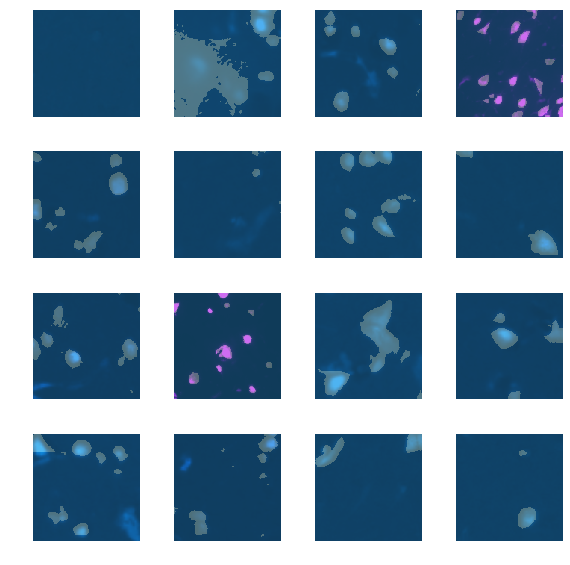

In [20]:
# do the masks align with the base image??
print("Overlay of masks on training images")
data.show_batch(rows=4, figsize=(8,8))

## 5. Training
---

#### **5.1. Model**

Choosing the model architecture.  

The model architecture can be provided using fastai syntax. Example:
- `model = simple_cnn((3,16,16,2))`  builds a cnn model with a binary output with following layers: 

The fastai library includes several pretrained models from torchvision, namely:
- resnet18, resnet34, resnet50, resnet101, resnet152
- squeezenet1_0, squeezenet1_1
- densenet121, densenet169, densenet201, densenet161
- vgg16_bn, vgg19_bn
- alexnet  

On top of the models offered by torchvision, fastai has implementations for the following models:

- Darknet architecture, which is the base of [Yolo v3](https://pjreddie.com/media/files/papers/YOLOv3.pdf)
- Unet architecture based on a pretrained model. The original unet is described [here](https://arxiv.org/abs/1505.04597), the model implementation is detailed in [models.unet](https://docs.fast.ai/vision.models.unet.html#vision.models.unet)
- Wide resnets architectures, as introduced in [this article](https://arxiv.org/abs/1605.07146)

In [21]:
# assign the model (pretrained or not)

model = models.resnet34 
#model = models.unet  # check this syntax.  
#model = simple_cnn((3,16,16,2))  

#### **5.2. Optimization Function**

Choose the optimization function. Options include:
- 'Adam'

Really Adam is the only one to use (for now). Fastai implementation uses decoupled weight regularization - don't know if this is true in pytorch. Adam combines elements of momentum with ....[ref](https://arxiv.org/abs/1711.05101)

In [22]:
opt_func = 'Adam'

#### **5.3. Loss Function**

Choose the loss function. Fastai defaults to None.

In [23]:
loss_func = None

#### **5.4. Learner**

Trainer for `model` using `data` to minimize `loss_func` with optimizer `opt_func`.

`Learner (data:DataBunch, model:Module, opt_func:Callable='Adam', loss_func:Callable=None, metrics:Collection[Callable]=None, true_wd:bool=True, bn_wd:bool=True, wd:Floats=0.01, train_bn:bool=True, path:str=None, model_dir:PathOrStr='models', callback_fns:Collection[Callable]=None, callbacks:Collection[Callback]=<factory>, layer_groups:ModuleList=None, add_time:bool=True, silent:bool=None, cb_fns_registered:bool=False)`

In [24]:
#learn = Learner(data, model)
#learn = cnn_learner(data, model)
#learn = unet_learner(data, model, opt_func=opt_func)  # not working
learn = unet_learner(data, model)
#learn = Learner.create_unet(data, model)   # not sure this works

#### 5.4.1. Metrics

In [25]:
# Metrics
# metrics always calculated on the validation set
# custom metric function (if needed):
def acc_custom(input, target):
    target = target.squeeze(1)
    return (input.argmax(dim=1)==target).float().mean()

#learn.metrics=acc_custom    # accuracy does not work on multilabel classification - the above metric doesn't work - images wrong sizes

learn.metrics=[dice]   # dice works, accuracy does not work.

#### 5.4.2. Callbacks

#### SaveModelCallback
Automatically saves the best model even if it happens in the middle of a training run.  see this post for best model callback: https://medium.com/@lessw/fastais-callbacks-for-better-cnn-training-meet-savemodelcallback-e55f254f1af5

1. monitor = “error_rate” Error rate is the preferred option, but you can also monitor other metrics such as validation_loss, etc.
- Examples include: 'error_rate', 'dice', 'validation_loss'
2. mode = ( auto | min |max) — use this to set the comparison operator for how the monitored metric should be compared. Auto is default and will try and determine if min or max is what you really want. I prefer to hard-set it to min or max to be safe.
3. name = use to set the name to save the best model under. The default name is simply “bestmodel” but I like to customize it with things like the resolution image size, or time of the training run, etc. to make the name more informative.
4. every = This controls when the ‘best model’ should be saved. By default it’s set to ‘improvement’ meaning it will save at the end of each epoch if the metric sets a new best value. I usually leave this to the default. ‘epoch’ is the other option and would simply save a new, individually tagged model at the end of each epoch regardless (ala modelname_epoch, or “bestmodel_3” for epoch 3).

In [33]:
# Callbacks to modify training
#cb = OneCycleScheduler(learn, lr_max=0.01)   # this function not working - not needed at the moment - revisit

# savemodelcallback
# example model name: 300-resnet34-0.0004
model_name = "{}-{}".format("resnet34", str(size))
callbacks = [ShowGraph(learn),
             SaveModelCallback(learn, 
                               every='improvement',  #
                               monitor='dice',       #
                               mode='max',           # set to 'max' with 'dice' score ('min' with 'error_rate')
                               name=model_name)]     #
learn.callbacks = callbacks

In [27]:
# display the model architecture - summary has more info - very long print out!
#learn.model      # just the model
#learn.summary    # model and data info

### 5.5. Learning Rate Finder

The learning rate finder function is performed each time the model architecture is changed. Will perform a learning rate search step-wise through a range. 

Other strategies for hyperparameter optimization include:   
Uninformed
- grid search (worst, uninformed)
- random search  (better, uninformed)  

Bayesian optimization (sequential model-based optimization)
- gaussian processes
- random forest regression
- Tree of Parzen Estimators (TPE) (hyperopt) [ref](https://papers.nips.cc/paper/4443-algorithms-for-hyper-parameter-optimization.pdf)


Bayesian optimization, also called Sequential Model-Based Optimization (SMBO), implements this idea by building a probability model of the objective function that maps input values to a probability of a loss: p (loss | input values). The probability model, also called the surrogate or response surface, is easier to optimize than the actual objective function. Bayesian methods select the next values to evaluate by applying a criteria (usually Expected Improvement) to the surrogate. The concept is to limit evals of the objective function by spending more time choosing the next values to try.


`lr_find(learn:Learner, start_lr:Floats=1e-07, end_lr:Floats=10, num_it:int=100, stop_div:bool=True, wd:float=None)`

wd:  weight decay. Use wd = 0.1 as a good starting point. "let’s not just add the sum of the squares of the parameters to the model but let’s multiply that by some number that we choose. And that number that we choose in fast is called wd"

In [28]:
# run learning rate finder
learn.lr_find(start_lr=1e-07, end_lr=10, wd=0.01)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


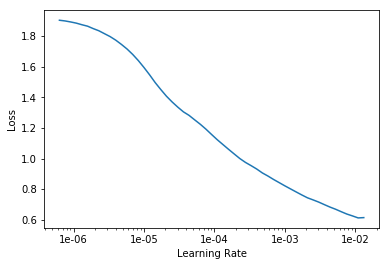

In [29]:
# plot the finder results
learn.recorder.plot()

In [30]:
# set the learning rate to be used in fitting the model.
#lr = 6e-4   # bs=12, 300x300
lr = 1e-3   # bs=12, 250x250

#### **5.6. Fit**

`fit_one_cycle(learn:Learner, cyc_len:int, max_lr:Union[float, Collection[float], slice]=slice(None, 0.003, None), moms:Point=(0.95, 0.85), div_factor:float=25.0, pct_start:float=0.3, final_div:float=None, wd:float=None, callbacks:Optional[Collection[Callback]]=None, tot_epochs:int=None, start_epoch:int=None)`

In [31]:
#learn.data.single_ds.tfmargs['size'] = None 

epoch,train_loss,valid_loss,dice,time
0,0.153135,0.138942,0.497074,00:16
1,0.145121,0.111192,0.519227,00:17
2,0.131930,0.086090,0.585668,00:17
3,0.121466,0.096605,0.638044,00:16
4,0.114716,0.080765,0.635455,00:16
5,0.109636,0.082064,0.612225,00:16
6,0.103949,0.087577,0.558804,00:16
7,0.099684,0.076141,0.674401,00:16
8,0.096099,0.073915,0.685520,00:16
9,0.093027,0.073778,0.683823,00:16


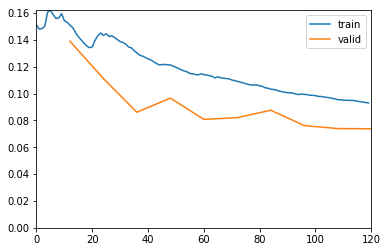

Better model found at epoch 0 with dice value: 0.4970737099647522.
Better model found at epoch 1 with dice value: 0.5192265510559082.
Better model found at epoch 2 with dice value: 0.5856680870056152.
Better model found at epoch 3 with dice value: 0.6380435228347778.
Better model found at epoch 7 with dice value: 0.6744011640548706.
Better model found at epoch 8 with dice value: 0.6855199337005615.


In [34]:
#n_epochs = 3
#learn.fit(epochs=n_epochs, callbacks=cb)
learn.fit_one_cycle(cyc_len=10, max_lr=slice(lr), wd=0.01)    # normaly set 'cyc_len'=3
#learn.save('mini_train')   # this saves to the 'data' dir under a dir labeled 'models' (under .fastai if not local)

In [1]:
''' 300x300, bs = 12, lr = 6e-04
epoch	train_loss	valid_loss	dice	time
0	0.256197	0.239062	0.096503	00:15
1	0.201206	0.124323	0.406645	00:13
2	0.166868	0.110258	0.522105	00:12
3	0.148771	0.105910	0.394364	00:12
4	0.135750	0.103627	0.623291	00:12
5	0.126832	0.095542	0.617538	00:12
6	0.119321	0.092763	0.630016	00:12
7	0.113496	0.087916	0.628634	00:12
8	0.108356	0.087551	0.640326	00:12
9	0.104686	0.086978	0.649062	00:12
'''

' 300x300, bs = 12, lr = 6e-04\nepoch\ttrain_loss\tvalid_loss\tdice\ttime\n0\t0.256197\t0.239062\t0.096503\t00:15\n1\t0.201206\t0.124323\t0.406645\t00:13\n2\t0.166868\t0.110258\t0.522105\t00:12\n3\t0.148771\t0.105910\t0.394364\t00:12\n4\t0.135750\t0.103627\t0.623291\t00:12\n5\t0.126832\t0.095542\t0.617538\t00:12\n6\t0.119321\t0.092763\t0.630016\t00:12\n7\t0.113496\t0.087916\t0.628634\t00:12\n8\t0.108356\t0.087551\t0.640326\t00:12\n9\t0.104686\t0.086978\t0.649062\t00:12\n'

#### 6. Training Results
---

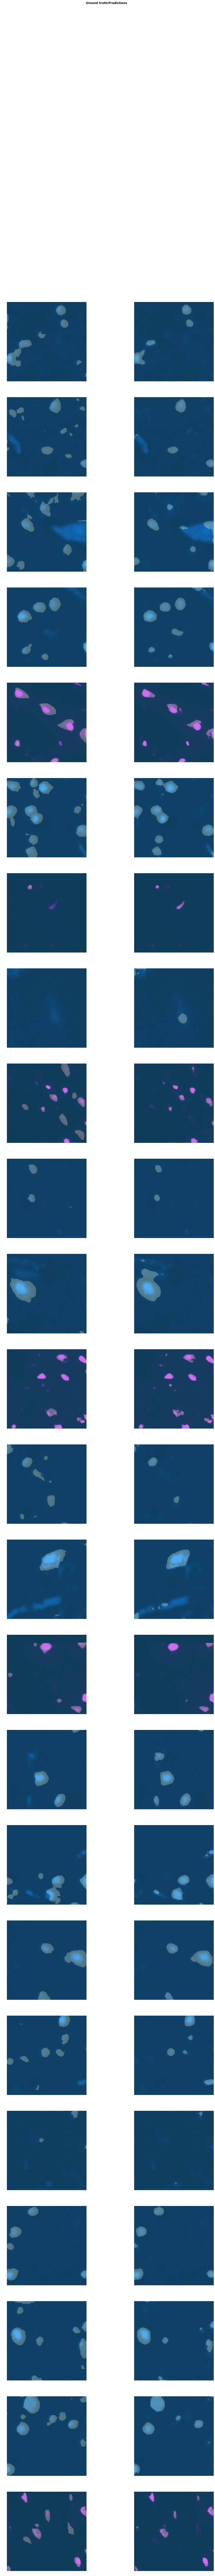

In [35]:
#learn.show_results() 250x250
learn.show_results(rows=40, figsize=(20,200))

#### Save the model.

### Make a prediction

In [36]:
# clear the cache? If you run learn.save() then 
# learn.load() one does not need to run learn.purge()

# Save the model to the model directory.
# save to learn.path/'models'
#learn.save()
learn.load(model_name)

Learner(data=ImageDataBunch;

Train: LabelList (293 items)
x: SegmentationItemList
Image (3, 250, 250),Image (3, 250, 250),Image (3, 250, 250),Image (3, 250, 250),Image (3, 250, 250)
y: SegmentationLabelList
ImageSegment (1, 250, 250),ImageSegment (1, 250, 250),ImageSegment (1, 250, 250),ImageSegment (1, 250, 250),ImageSegment (1, 250, 250)
Path: data/images_sliced_250;

Valid: LabelList (73 items)
x: SegmentationItemList
Image (3, 250, 250),Image (3, 250, 250),Image (3, 250, 250),Image (3, 250, 250),Image (3, 250, 250)
y: SegmentationLabelList
ImageSegment (1, 250, 250),ImageSegment (1, 250, 250),ImageSegment (1, 250, 250),ImageSegment (1, 250, 250),ImageSegment (1, 250, 250)
Path: data/images_sliced_250;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
   

In [ ]:
# deployment
#learn.export(model_name)

# use this code to create a learner object from the exported model
#learn = load_learner(path, 'trained_model.pkl')

In [39]:
pred = learn.predict(open_image(Path('data/images_beta/TrainingData_1_original.tif')))

In [40]:
pred

(ImageSegment (1, 250, 250), tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]), tensor([[[0.9366, 0.9503, 0.9721,  ..., 0.7564, 0.9078, 0.8752],
          [0.9510, 0.9532, 0.9590,  ..., 0.9355, 0.9519, 0.9686],
          [0.9642, 0.9641, 0.9748,  ..., 0.9187, 0.9016, 0.9549],
          ...,
          [0.9851, 0.9794, 0.9593,  ..., 0.9771, 0.9820, 0.9743],
          [0.9828, 0.9882, 0.9859,  ..., 0.9424, 0.9584, 0.9223],
          [0.9476, 0.9574, 0.9504,  ..., 0.9694, 0.9566, 0.8879]],
 
         [[0.0634, 0.0497, 0.0279,  ..., 0.2436, 0.0922, 0.1248],
          [0.0490, 0.0468, 0.0410,  ..., 0.0645, 0.0481, 0.0314],
          [0.0358, 0.0359, 0.0252,  ..., 0.0813, 0.0984, 0.0451],
          ...,
          [0.0149, 0.0206, 0.0407,  ..., 0.0229, 0.0180, 0.0257],
          [0.0172, 0.0118, 0.0141,  ..., 0.057

https://forums.fast.ai/t/segmentation-mask-prediction-on-different-input-image-sizes/44389
A1:  
You need either need to create a new DataBunch with the desired size then load your model (with learn.load) or hack into where the size is store if you export your Learner, which is in learn.data.train_ds.tfmargs (and same with valid_ds, test_ds if applicable). At inference, I think it uses the transforms of single_dl so you might have to do

learn.data.single_dl.dataset.tfmargs['size'] = bla
but not entirely sure.

A2:  
Thanks a lot @sgugger, change learn.data.single_ds.tfmargs['size'] = None to predict one image per time worked like a charm!



### Clear the VM memory

In [1]:
torch.cuda.empty_cache()

NameError: name 'torch' is not defined

In [1]:
from pynvml import *
nvmlInit()
handle = nvmlDeviceGetHandleByIndex(0)
info = nvmlDeviceGetMemoryInfo(handle)
print("Total memory:", info.total)
print("Free memory:", info.free)
print("Used memory:", info.used)

Total memory: 15812263936
Free memory: 15812263936
Used memory: 0


In [37]:
assert False, "please liberate my GPU!"

AssertionError: please liberate my GPU!

## 7. Next Steps
---

Image location - where are the predicted pixels located?